# Analysis Notebook for 2311.10491
This Jupyter notebook contains important plots present in the paper with relevant descriptions. The first cell contains importing of relevant packages and code, make sure dependencies are fulfilled and compatible. 

The notebook is divided into sections:
- [Initializing](#initializing)
- [Emulator Training and Validation](#emulator-description)
- [Results: Posterior Distribution](#corner-plot)
- [Calculations using Model Parameters](#calculations-using-model-parameters)

TO DO:
1. Fix hyperlinks
2. sklearn

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [161]:
from my_plotting import *
from my_functions import *
sns.set()
sns.set_style('ticks')
from scipy.optimize import basinhopping
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'axes.labelsize': 18,
                     'axes.titlesize': 22,
                     'legend.fontsize': 16,
                     'legend.title_fontsize': 14,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',})

# Initializing <a id='initializing'></a>
Load important files and data:
- pickled emulator, pca, and scaler
- training and validation set
- parameter set
- experimental data in relevant kinematical range
- parameter samples
- posterior samples (or just sample from the complete set)
- model values for posterior samples

In [162]:
# first decide if we are dealing with correlated setup and which model
correlated_ = True 
model_ = "mv5" # or "mv5" for the 5 parameter case

In [163]:
correlated_str = "corr" if correlated_ else "uncorr"
param_names = ["$Q_{s,0}^{2}$ [GeV²]",
               "$\gamma$ ",
               "$e_c$ ",
               "$C^2$ ",
               "$\sigma_0/2$ [mb] "] if model_ == "mv5" else ["$Q_{s,0}^{2}$ [GeV²]",
               "$e_c$ ",
               "$C^2$",
               "$\sigma_0/2$ [mb]"]
n_params = 5 if model_ == "mv5" else 4
# all files
folder = 'data/' + model_ + '/' + correlated_str
exp_file = "data/hera_allerrors.csv"
gpe_pkl = folder+"/gpe.pkl"
pca_pkl = folder+"/pca.pkl"
scaler_pkl = folder+"/scaler.pkl"
train_file, theta_file = 'data/'+model_+"/training/train.dat", 'data/' +model_+"/training/theta.dat"
train_file_val, theta_file_val = 'data/'+model_+"/validation/train.dat", 'data/'+model_+"/validation/theta.dat"
theta_post_all_file = folder+"/theta_all.dat"
train_file_post, theta_file_post = folder+"/train.dat", folder+"/theta.dat"
theta_post_1000_file = folder+"/theta_1000.dat"
mean_model_file = folder+"/mean.dat"
median_model_file = folder+"/median.dat"
map_model_file = folder+"/map.dat"

In [164]:
# load from files 
# Emulator and emulator predictions
# gpe = loadfrompickle(gpe_pkl) 
# pca = loadfrompickle(pca_pkl)
# scaler = loadfrompickle(scaler_pkl)
# emulators = [gpe, pca, scaler]
# error message:
# fix error with __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given
# sklearn version compatibitility does not fix, try overall package compatibility

# emulator training
train, theta = load_training_data(train_file, theta_file)
npc =  6 # dont change
emulators = train_PCA_GPE(train, theta, primary_components = npc, noise_level_bounds_= (1e-10, 1e1), show_var = True)
pred, err = return_predictions(emulators, theta, correlated=correlated_)

# emulator validation
train_val, theta_val = load_training_data(train_file_val, theta_file_val)
pred_val, err_val = return_predictions(emulators, theta_val, correlated=correlated_)

# emulator and bayesian posterior validation
train_post, theta_post = load_training_data(train_file_post, theta_file_post)
pred_post, err_post = return_predictions(emulators, theta_post, correlated=correlated_)

# Posterior samples
theta_post_all = np.vstack(np.loadtxt(theta_post_all_file))
theta_post_1000 = np.vstack(np.loadtxt(theta_post_1000_file, comments="#"))

# Experimental dataframe with columns:
exp_df, exp, exp_err, xbj = load_exp(exp_file, correlated = correlated_)

# bounds of the prior
l_bounds = [0.04, 0.9, 0.5, 2.0, 12.0] if model_ == "mv5" else [0.04, 0.5, 2.0, 12.0]
u_bounds = [0.11, 1.1, 60.0, 10.0, 18.0] if model_ == "mv5" else [0.11, 60.0, 10.0, 18.0]

# mean, median and map values
median = np.median(theta_post_all, axis=0).reshape(1,-1)
mean = np.mean(theta_post_all, axis=0).reshape(1,-1)
median_84= np.percentile(theta_post_all, 84, axis=0).reshape(1,-1)
median_16= np.percentile(theta_post_all, 16, axis=0).reshape(1,-1)
median_95= np.percentile(theta_post_all, 97.5, axis=0).reshape(1,-1)
median_5= np.percentile(theta_post_all, 2.5, axis=0).reshape(1,-1)
MAP = basinhopping(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err, correlated = correlated_), median.reshape(-1)).x
MAP = MAP.reshape(1,-1)

# get model calculations with mean, median and map values
median_model = np.loadtxt(median_model_file)
mean_model = np.loadtxt(mean_model_file)
MAP_model = np.loadtxt(map_model_file)

Sum of explained variance ratio for 6 components: 0.999999918229108


In [165]:
np.set_printoptions(precision=3)
print("Parameter name order:", param_names)
print("Mean =", mean)
print("Median =", median)
print("Median - 2.5 percentile =", median - median_5)
print("97.5 percentile - Median =", median_95 - median)
print("MAP", MAP)

Parameter name order: ['$Q_{s,0}^{2}$ [GeV²]', '$\\gamma$ ', '$e_c$ ', '$C^2$ ', '$\\sigma_0/2$ [mb] ']
Mean = [[ 0.071  1.011 29.041  4.827 13.971]]
Median = [[ 0.067  1.009 27.51   4.718 13.965]]
Median - 2.5 percentile = [[1.547e-02 2.646e-02 2.300e+01 1.577e+00 1.244e+00]]
97.5 percentile - Median = [[ 0.041  0.04  31.016  2.523  1.317]]
MAP [[ 0.077  1.014 15.636  4.467 13.859]]


In [166]:
# chi² or likelihood values of mean, median and MAP
print("chi2/dof values for mean, median, MAP, and average over 100 posterior samples such that the correlation among uncertainties were not considered" )
print("mean:", get_chi2(mean_model, exp, exp_err, correlated = correlated_, model = model_))
print("median:", get_chi2(median_model, exp, exp_err, correlated = correlated_, model=model_))
print("MAP:", get_chi2(MAP_model, exp, exp_err, correlated = correlated_, model=model_))
all_chi2 = []
for i in range(100):
    all_chi2.append(get_chi2(train_post[i], exp, exp_err, correlated = correlated_, model = model_))
print('for 100 samples:', np.mean(all_chi2))

chi2/dof values for mean, median, MAP, and average over 100 posterior samples such that the correlation among uncertainties were not considered
mean: 1.2180282344891085
median: 1.01642099625224
MAP: 1.0123583095205282
for 100 samples: 1.0250384134927248


# Emulator Training Description and Validation <a id='emulator-description'></a>
The training set is generated by sampling the parameter space with a latin hypercube design. The parameter space is defined by the following parameters: $Q_{s0}^2$, $\gamma$, $e_c$, $C^{2}$, $\sigma_0/2$. The final prior bounds used in the study is a result of multiple iterations of the Bayesian sampling and each time making, what was initially, a very generous parameter space even smaller for better emulator predictions. In a latin hypercube, the parameter vectors for the model to be calculated on and the emulator to be trained on are sampled evenly across the space such that there is no redundancy in each individual parameter. 

The plot we see below is a distribution of a pair of parameters. We can see that the parameter points are evenly distributed across the prior space.

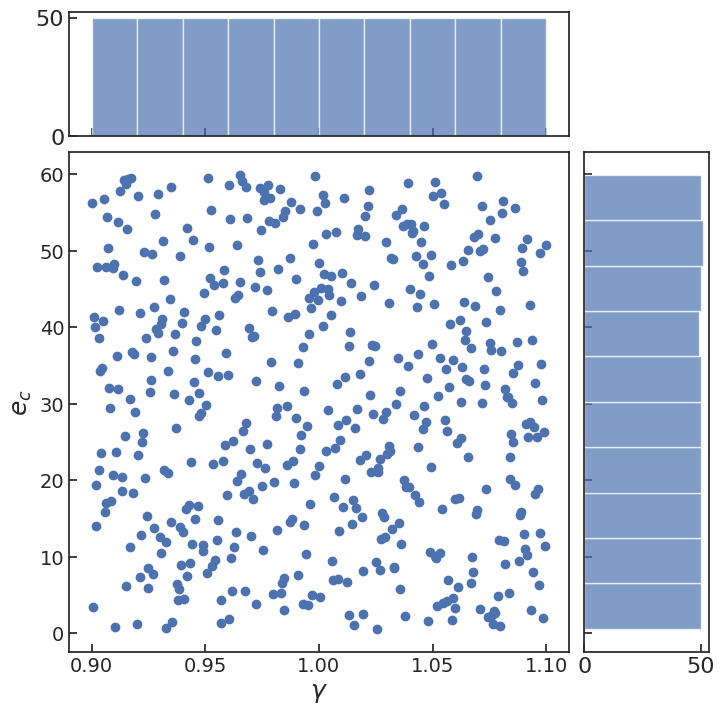

In [167]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(1, 2, ax, ax_histx, ax_histy, theta, param_names)

## Emulator Validation
The following shows comparison of emulator prediction to HERA data and model calculation to a validation set of 100 parameter vectors (not included in the training data) to validate the emulator before giving it into the bayesian sampler. The first figure is a plot of the validation set (red x's) and the emulator prediction (blue markers) show the agreement between model and emulator (errorbars not very visible). The red line is the experimental data.

The next figure is a simple comparison plot between emulator and model over all consider kinematical points. The last figure is a zscore distribution calculated using 
$$ z = \frac{GPE - model}{\sigma_{GPE}} $$
where $\sigma_{GPE}$ is the variance of the GPE prediction. Mean and SD of the zscore distribution is also shown. 

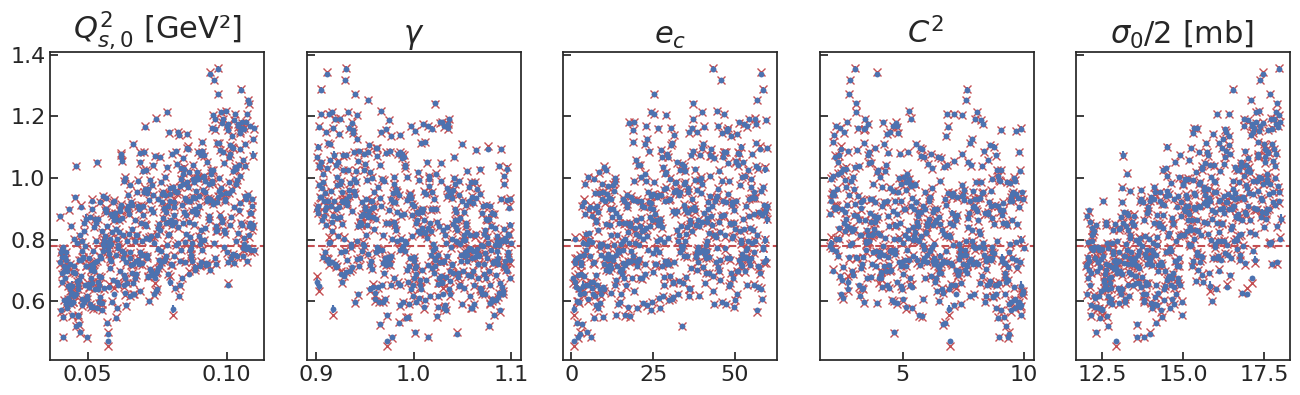

In [168]:
kp = 0
sd_val = np.sqrt(np.diagonal(err_val, axis1 = 1, axis2 = 2)) if correlated_ else err_val
fig, ax = plot_validation_perkp(0, pred_val, sd_val, train_val, exp, n_params, theta_val, param_names)

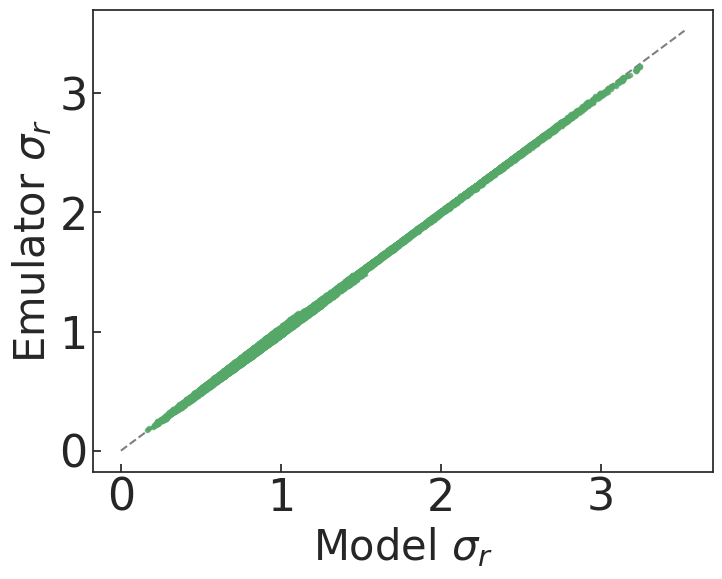

In [169]:
fig, ax = plot_diagonal(pred_val, train_val)
ax.xaxis.get_label().set_fontsize(30)
ax.yaxis.get_label().set_fontsize(30)
ax.tick_params(axis='both', which='major', labelsize=32)
fig.savefig("plots/{}_val_diagonal.pdf".format(model_), bbox_inches='tight')
fig.savefig("plots/{}_val_diagonal.png".format(model_), bbox_inches='tight')

In [170]:
diff = np.array([(pred_val[:,kp] - train_val[:,kp])/train_val[:,kp] for kp in range(403)])
mean_pertheta = np.mean(diff, axis=1)
mean_all = np.mean(mean_pertheta)
print("mean relative error between model and emulator =", mean_all)

mean relative error between model and emulator = 0.0004730141161155856


norm_fit =  0.8435653215705728


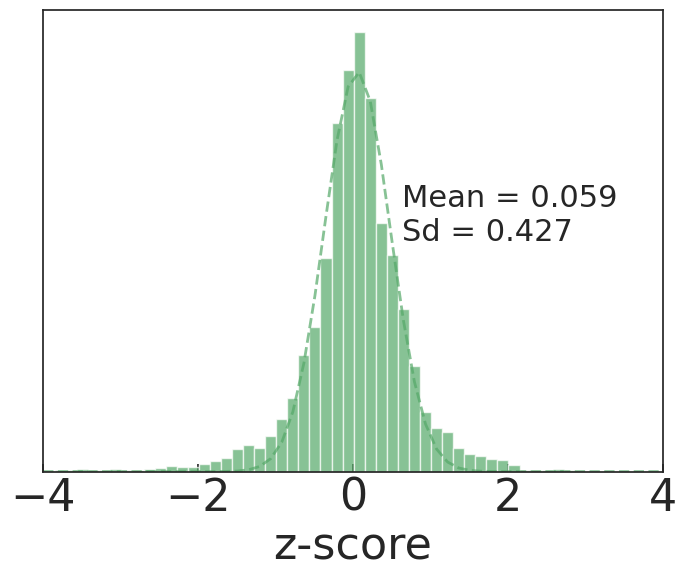

In [171]:
fig, ax = plot_zscore(pred_val, train_val, sd_val, bins_ = 80, text_x = 0.58, text_y = 0.5)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.tick_params(which='major', axis = 'y', size = 0)
ax.set_xlim(-4.0, 4.0)
ax.xaxis.get_label().set_fontsize(32)
ax.tick_params(axis='x', which='major', labelsize=32)
#ax.legend(fontsize=22, loc='upper left')
fig.savefig("plots/{}_val_zscore_notarget.pdf".format(model_), bbox_inches='tight')

# Posterior Distributions: Corner plots
Running the MCMC results to a posterior distribution describing the areas of high posterior probability. Diagonal plots of the triangle diagram are 1D projections of the posterior distribution for each parameter. The off-diagonal plots are 2D projections of the posterior distribution for each pair of parameters that show the correlation between the pair. First comparison corner plots are between the setup where correlation between experimental uncertainties are considered and the setup where it is not. Next we show the current setup and comparing the 5 parameter case to the 4 parameter case. Note that in this code we name the 5 parameter set up as 'mv5' and the 4 parameter set up as 'mve'.

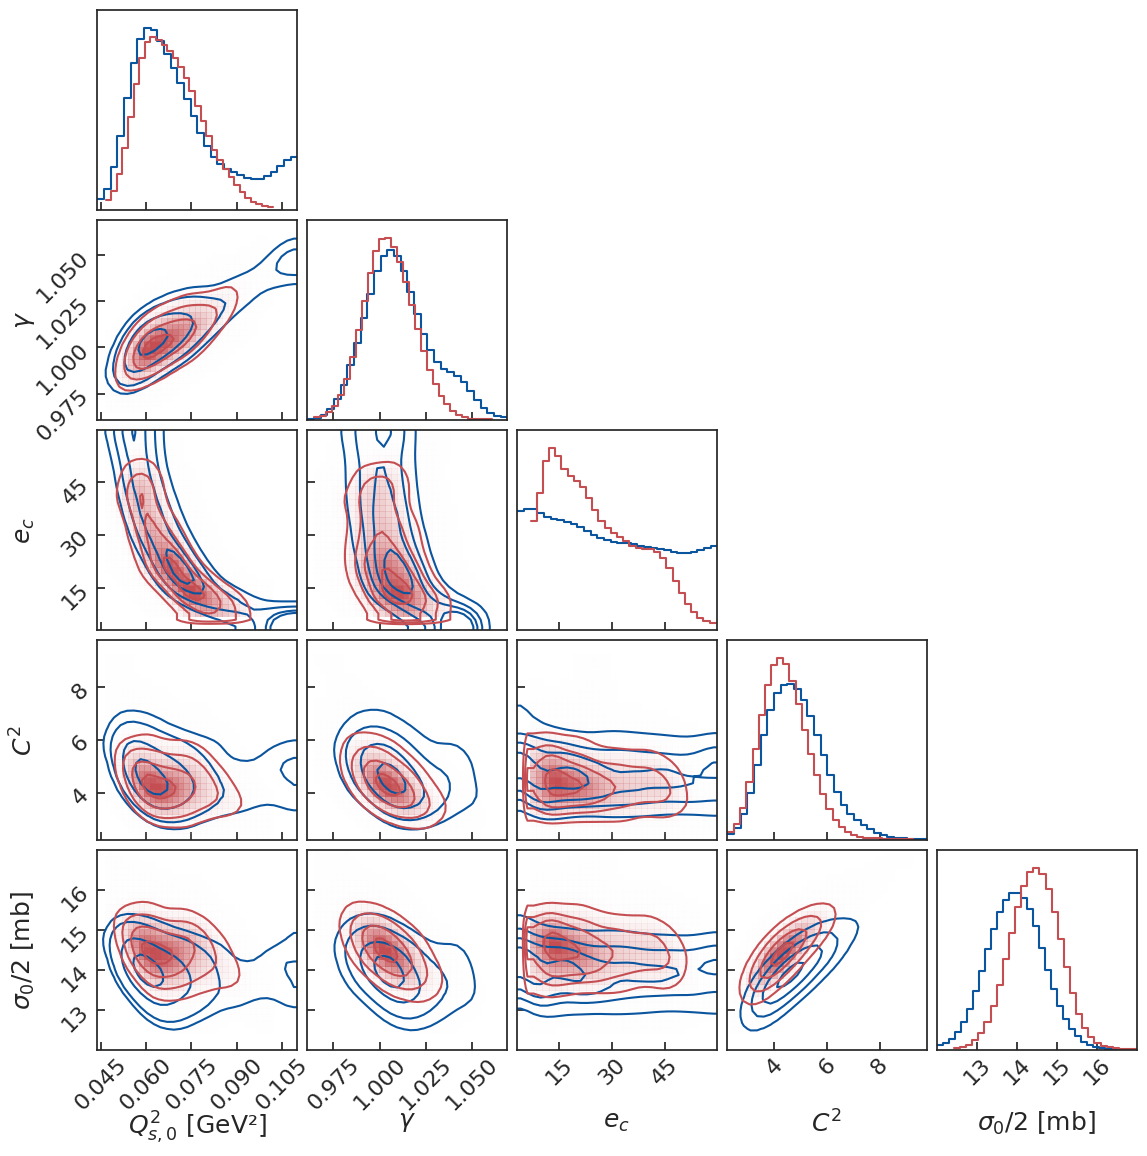

In [172]:
correlated_str_opp = "uncorr" if correlated_ else "corr"
theta_tocompare = np.vstack(np.loadtxt("data/{}/{}/theta_all.dat".format(model_, correlated_str_opp), unpack = True)).T
fig2, corner = plot_1corner(theta_post_all, param_names, color_= '#0b559f')
plot_corner_tocompare(theta_tocompare, fig2, corner, color_ = 'r')
fig2.savefig("plots/corr_vs_uncorr_corner.pdf", bbox_inches='tight')

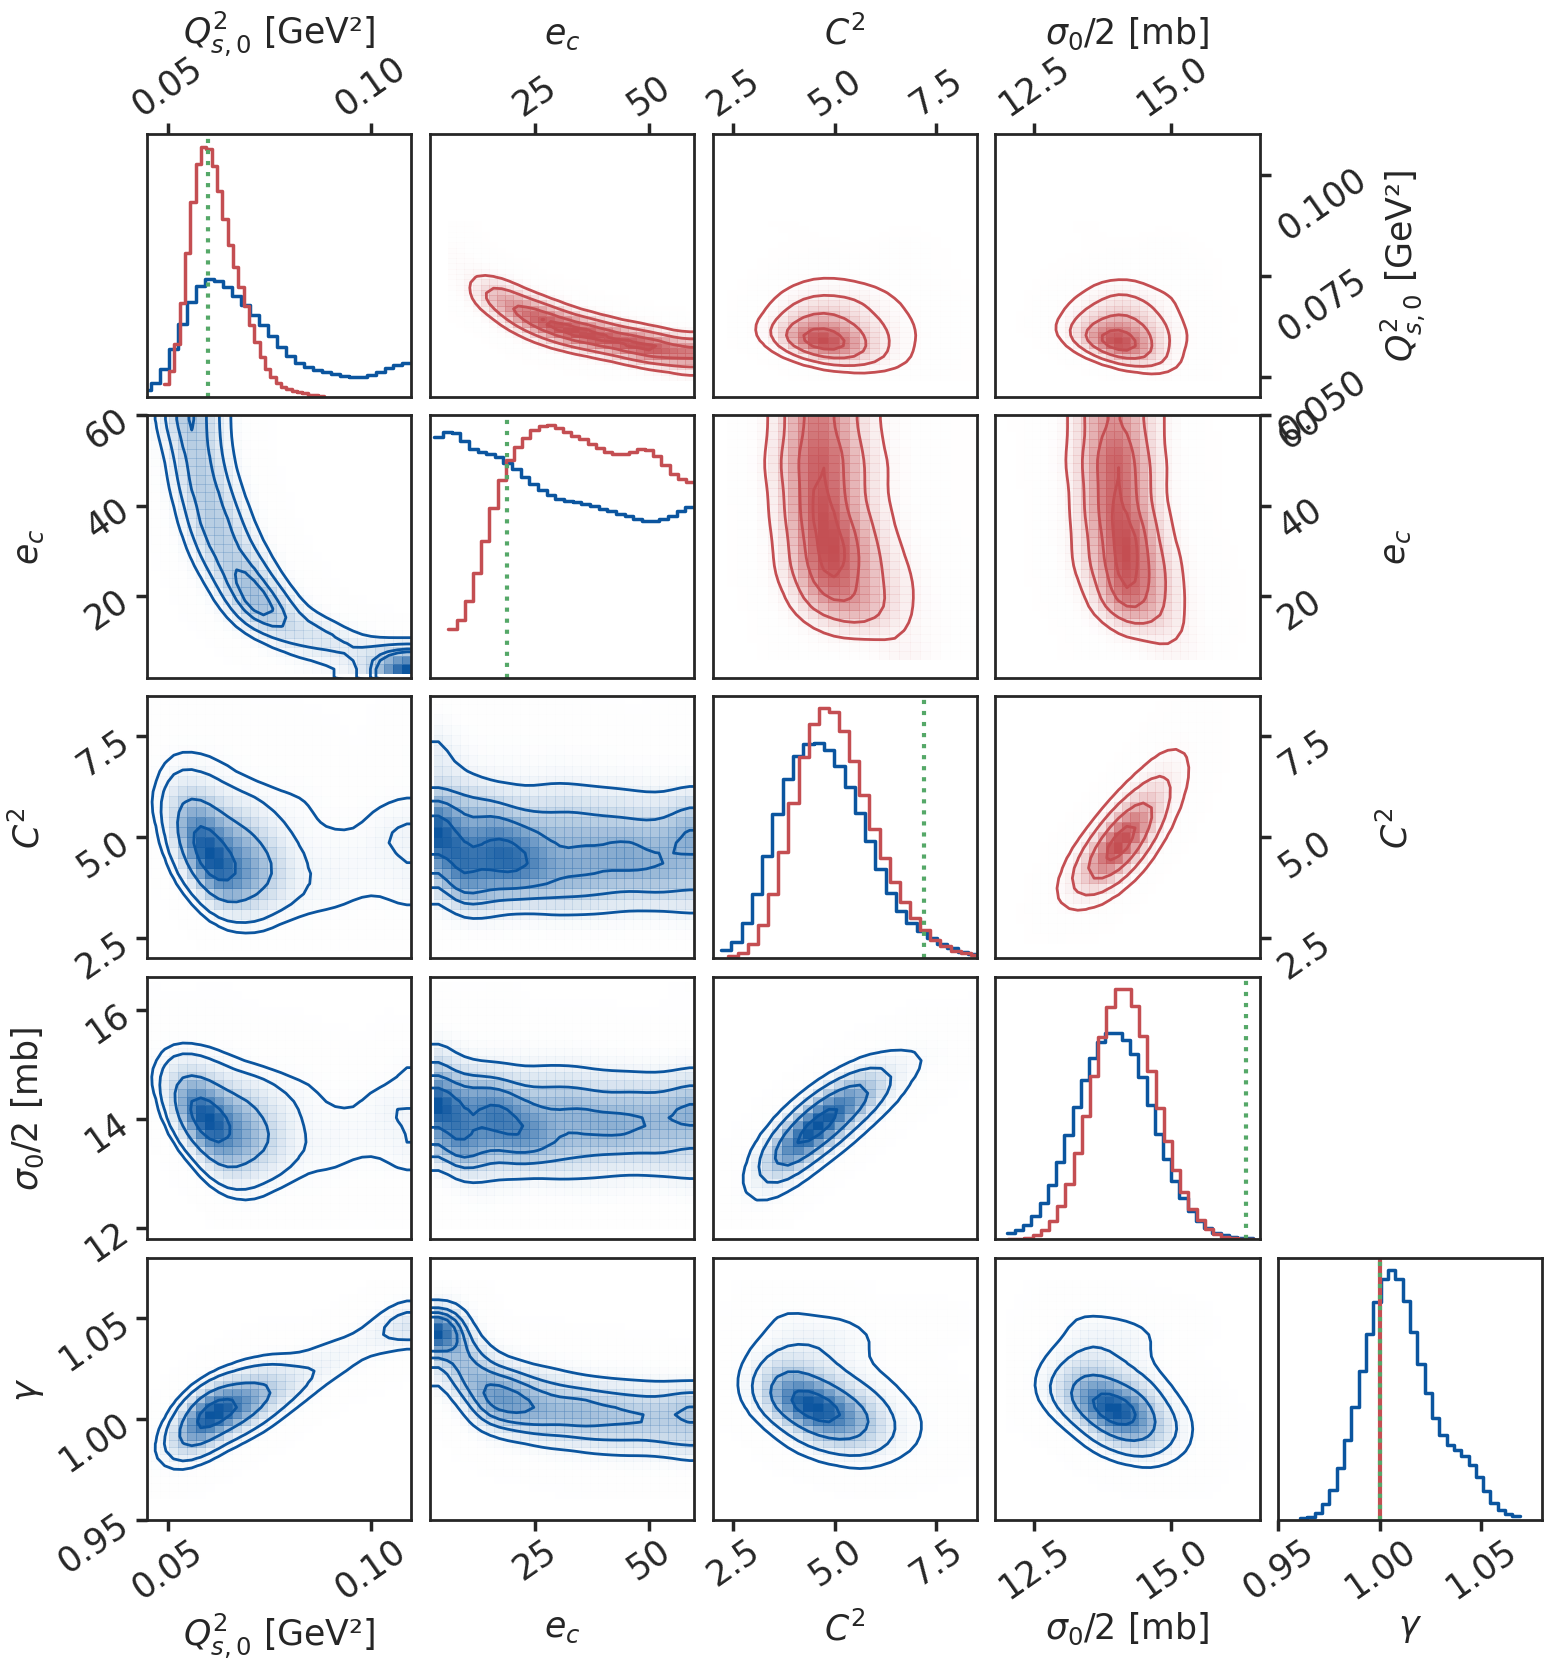

In [173]:
posterior_samples_mve= np.vstack(np.loadtxt("../BayesianBK/run_corr/mve/plainLHS/run2_mve_500d_{}_05to60_100w_mapinit_allsamples.txt".format(correlated_str), unpack=True)).T
posterior_samples_mv5 = theta_post_all
posterior_samples_mv5 = np.insert(posterior_samples_mv5, 5, posterior_samples_mv5[:, 1], axis = 1)
posterior_samples_mv5 = np.delete(posterior_samples_mv5, 1, axis = 1)
posterior_samples_mve_gamma = 1.0*np.ones(len(posterior_samples_mve))
posterior_samples_mve = np.insert(posterior_samples_mve, 4, posterior_samples_mve_gamma, axis = 1)
posterior_samples_mve[0:200, 4] = 1.0
fig_corner, axes = plot_corner(posterior_samples_mve, posterior_samples_mv5, color_mve = 'r', color_mv5='#0b559f')
fig_corner.savefig("plots/{}_corner_clean.pdf".format(correlated_str), bbox_inches='tight')

## Posterior Validation
Next we visualize different results from sampling from the posterior and then comparing to HERA data. We use 100 random samples from the posterior distribution. We can easily visualize its agreement with the HERA data by calculating (using the rcbk code) the model for these parameter sets. The following figure will then show you the mean (calculated model first and THEN took the mean for a 100 parametrizations) and asymmetric uncertainty band. 

In [174]:
median_emulator, median_emulator_err = return_predictions(emulators, median, correlated=correlated_)
MAP_emulator, MAP_emulator_err = return_predictions(emulators, MAP, correlated=correlated_)

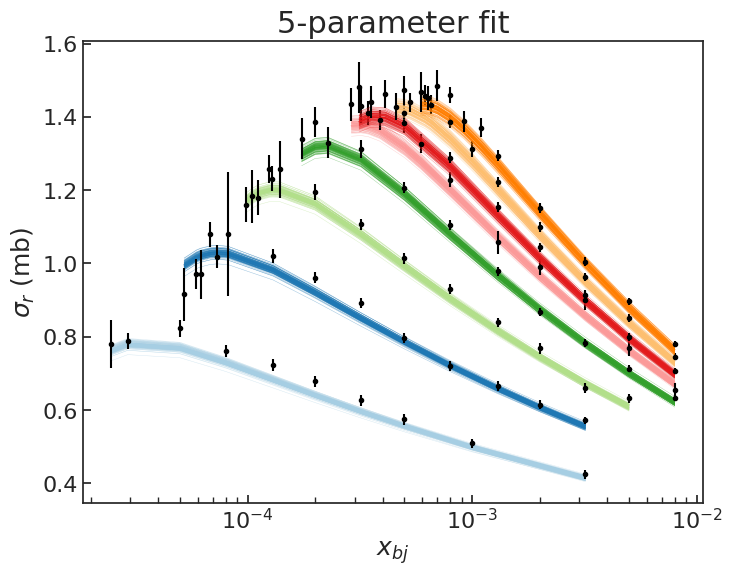

In [175]:
fig, ax = plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, train_post, exp_df, exp_err, title_ = "{}-parameter fit".format(n_params), correlated = correlated_)
ax.set_xscale('log')

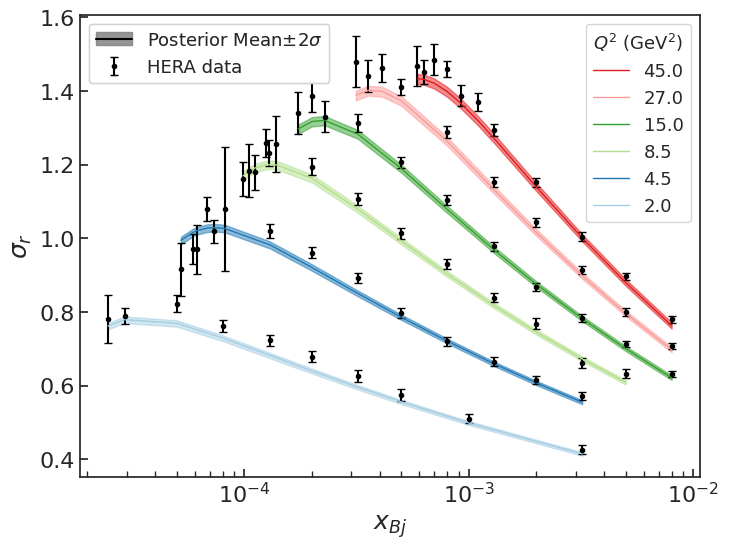

In [176]:
sqrt_s = 318
n_sigma = 2
fig, ax = plot_posterior_mean_and_ub([2., 4.5, 8.5, 15.0, 27., 45.], sqrt_s, train_post, exp_df, exp_err, n_sigma, title_ = "", correlated = correlated_)
fig.savefig("plots/{}_{}_{}_{}sigma_posterior_mean_and_ub.pdf".format(model_, correlated_str, sqrt_s, n_sigma), bbox_inches='tight')

In [177]:
#plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAP_model.reshape(1,403), exp_df, exp_err, median_model.reshape(1,403), correlated = correlated_)

The following validations plots are comparison between model and emulator but using the 100 parameter samples as validation set.

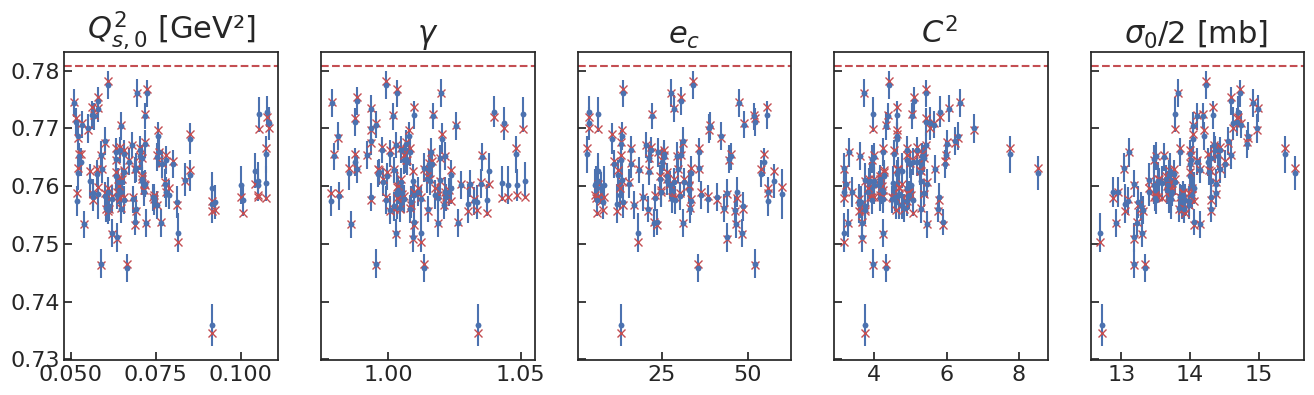

In [178]:
sd_post = np.sqrt(np.diagonal(err_post, axis1 = 1, axis2 = 2)) if correlated_ else err_post
fig, ax = plot_validation_perkp(0, pred_post, sd_post, train_post, exp, n_params, theta_post, param_names)

norm_fit =  1.098610621139205


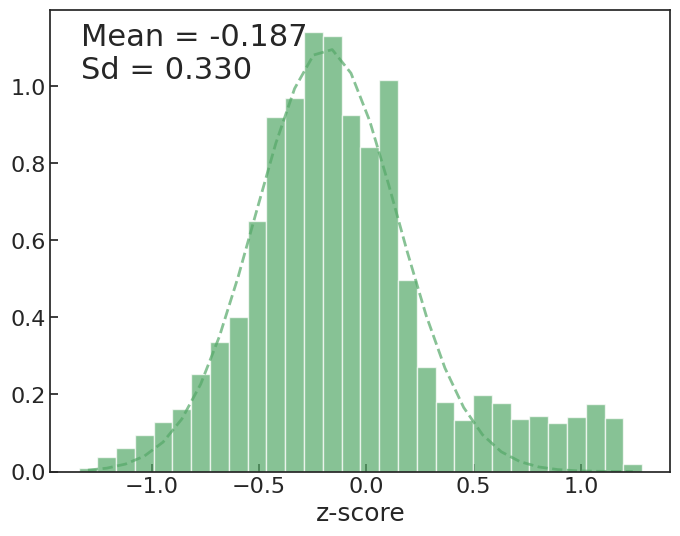

In [179]:
fig, ax = plot_zscore(pred_post, train_post, sd_post, text_x = 0.05, text_y = 0.85)

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Model $\\sigma_r$', ylabel='Emulator $\\sigma_r$'>)

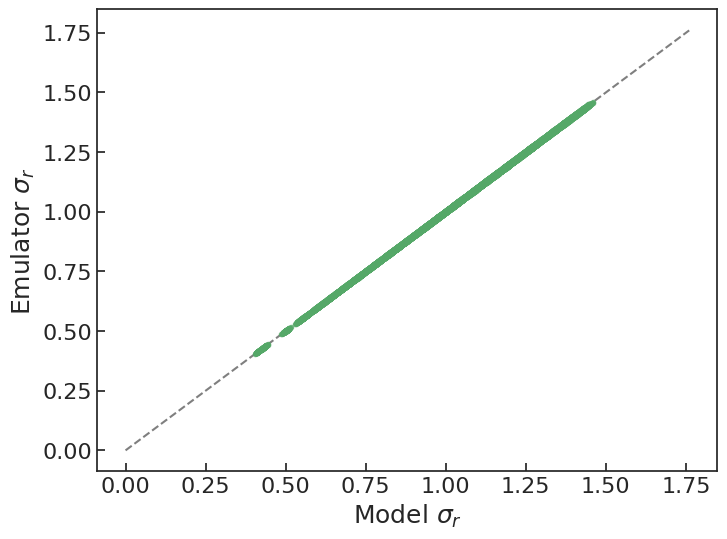

In [180]:
plot_diagonal(pred_post, train_post)

Finally, we compare the model calculated using only the median or MAP parametrization and the experimental data. 

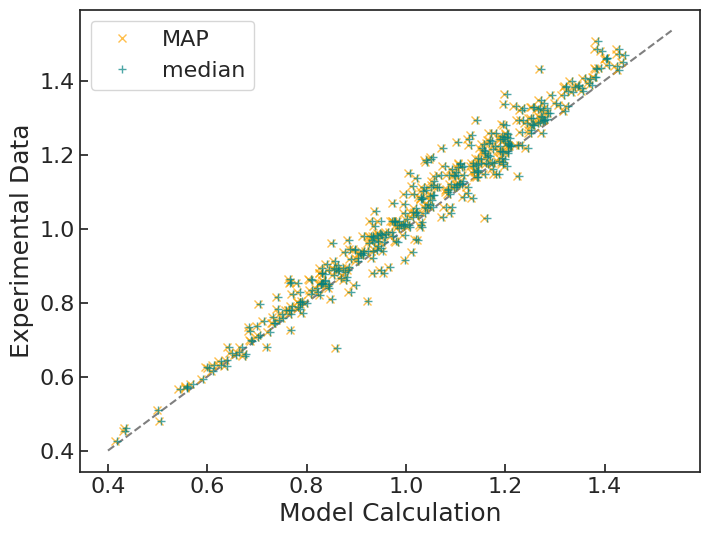

In [181]:
fig3, ax3 = plot_diagonal_1(MAP_model.reshape(403), exp, color_ = 'orange',label_ = "MAP")
ax3.plot(median_model.reshape(403), exp, '+', color = 'teal', alpha = 0.7, label  = "median" )
ax3.legend()
fig3.savefig("plots/{}_{}_{}_diagonal.pdf".format(model_, correlated_str, 'mapnmedian'), bbox_inches='tight')

# Applications: Calculations using Model Parameters
For the following predictions, we take 1000 samples from the posterior distribution and statistically rigorously calculate the median and standard deviation by calculating the quantity for 1000 of the samples and take the mean and sd for each x-value. We demonstrate here how to properly propagate the BK initial condition uncertainty to CGC calculations.

Visually, as we show in the following plot, there is no significant difference between the distributions of all parameters samples vs when we take only 1000 random samples meaning there is enough statistics in the posterior distributions made of 1000 samples. The ancillary files in 2311.10491 contain these 1000 samples for all the set ups we consider.

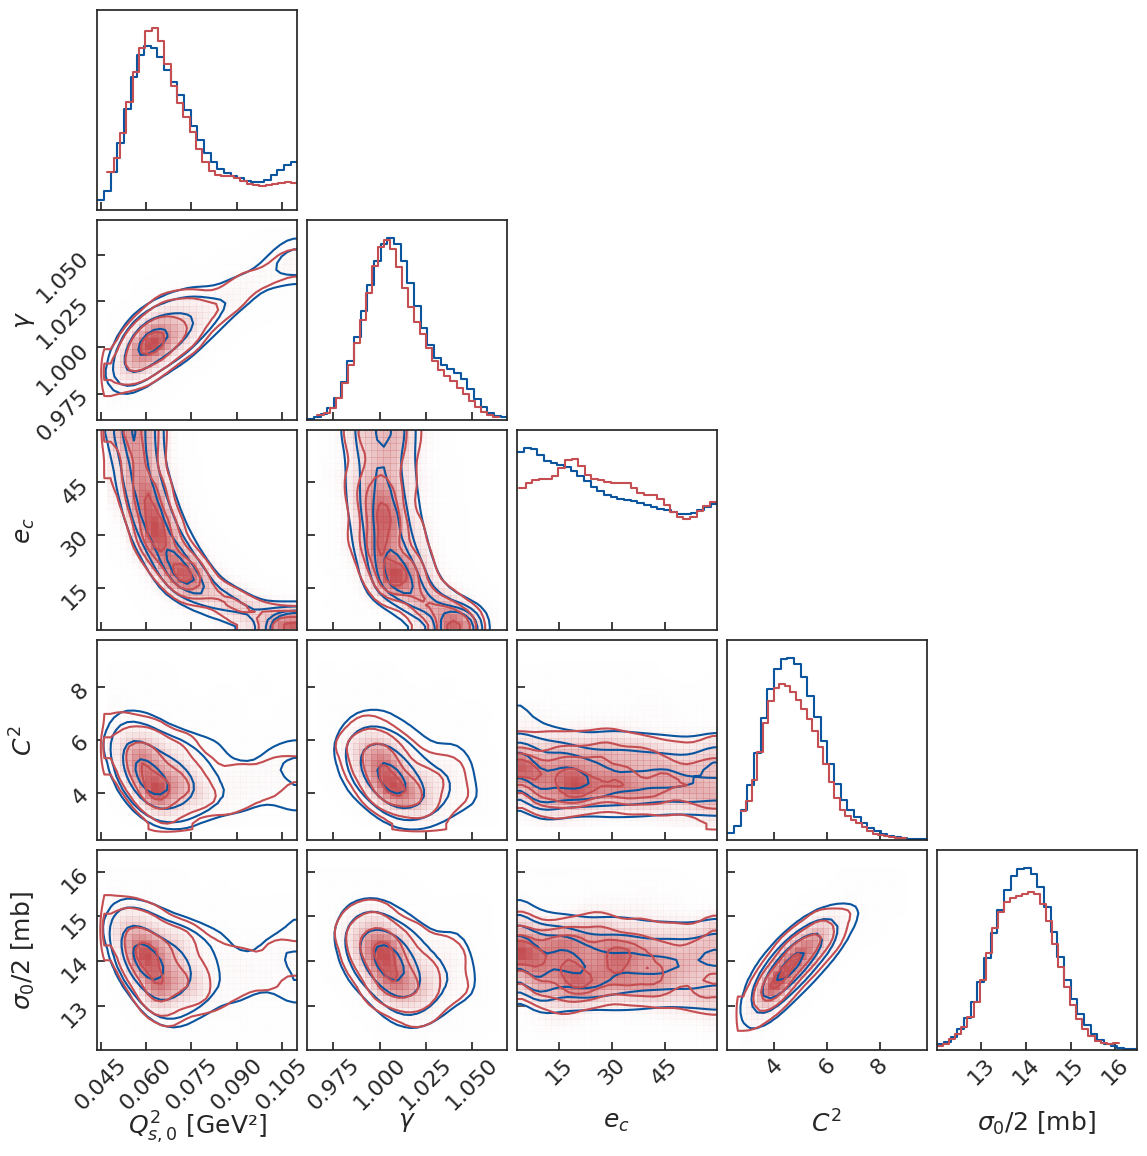

In [182]:
fig2, corner = plot_1corner(theta_post_all, param_names, color_= '#0b559f')
plot_corner_tocompare(theta_post_1000, fig2, corner, color_ = 'r')
fig2.savefig("plots/{}_{}_corner_allvs1000samples.pdf".format(model_, correlated_str), bbox_inches='tight')

In [183]:
# unravel the parameter vectors
e_cs = theta_post_1000[:, 2] if model_ == "mv5" else theta_post_1000[:, 1]
Qs02s = theta_post_1000[:, 0]
sigma02s = theta_post_1000[:, -1]
gammas = theta_post_1000[:, 1] if model_ == "mv5" else np.ones(1000)
C2 = theta_post_1000[:, 3] if model_ == "mv5" else theta_post_1000[:, 2]

Now we set up the other model as point of comparison as we calculate other observables from propagating the initial BK condition uncertainty. 

In [184]:
model_to_comp = "mv5" if model_ == "mve" else "mve"
theta_tocomp = np.vstack(np.loadtxt("data/{}/{}/theta_all.dat".format(model_to_comp, correlated_str), unpack=True)).T
theta_tocomp_1000 =  np.vstack(np.loadtxt("data/{}/{}/theta_1000.dat".format(model_to_comp, correlated_str), unpack=True)).T
e_cs_comp = theta_tocomp_1000[:, 2] if model_to_comp == "mv5" else theta_tocomp_1000[:, 1]
Qs02s_comp = theta_tocomp_1000[:, 0]
sigma02s_comp = theta_tocomp_1000[:, -1]
gammas_comp = theta_tocomp_1000[:, 1] if model_to_comp == "mv5" else np.ones(1000)
C2 = theta_post_1000[:, 3] if model_ == "mv5" else theta_post_1000[:, 2]

# Initial Saturation Scale

In this work we define $ Q_{s,0}$ as the parameter related to, but not entirely equal to, the initial saturation scale. The initial saturation scale we set to be the solution $ N = 1 - e^{-1/2} $ when $ r^{2} = 2/Q_{s}^{2} $. Below we compute the corresponding $ Q_{s} $ for the median and MAP values of the posterior distribution.

In [185]:
# solving for corresponding qs2
from scipy.optimize import newton
def func_r(x, qs02, gamma, e_c):
    lambda_qcd = 0.241
    A = qs02**(gamma)/4
    B = 1/lambda_qcd
    C = np.exp(1)*e_c
    func = A*x**(2*gamma) * np.log(B/x + C) - 1/2
    return func

gamma = 1.01 #1.01 #1.0 #1.0
qs02 = 0.077 #0.067 #0.060 #0.061
e_c = 15.6 #27.5 #38.9 #35.3
r = newton(func_r, 0.1, args = (qs02, gamma, e_c))
qs2 = 2/r**2
print(qs2)

0.28952101343212017


In [186]:
#making a plot of Qs2 as a function of x, compute for many samples. HOW? ReadBKdiople probably
def func_r_evolved(r, bk_interp, x):
    x0 = 0.01 # 10⁻2
    #xbj = 0.00001 # 10⁻5
    y_int = np.log(x0/x)
    func = bk_interp(y_int, r) - (1 - np.exp(-1/2))
    return func

where_bk_folder = "data/{}/corr/bks".format(model_)
bk_interpolators = [ReadBKDipole(where_bk_folder + "/{}.dat".format(i)) for i in range(100)]
x = 0.00001
r = newton(func_r_evolved, 0.1, args = (bk_interpolators[1], x))
qs2 = 2/r**2 
print(qs2)

1.3527406605368808


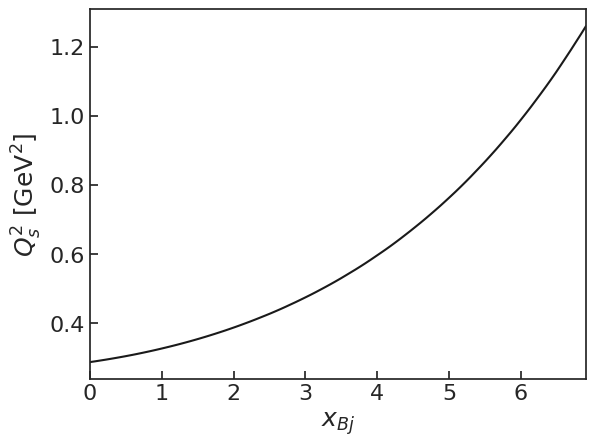

In [203]:
where_bk_folder = "data/{}/corr/bks".format(model_)
bk_interpolators = [ReadBKDipole(where_bk_folder + "/{}.dat".format(i)) for i in range(100)]
xs = np.logspace(-5, -2, 100)
mean = []
up_sd = []
low_sd = []
for x in xs:
    val_per_x = [newton(func_r_evolved, 1.0, args = (bk_interpolators[i], x)) for i in range(100)]
    val_per_x = np.array(val_per_x)
    qs2 = 2/val_per_x**2
    qs2_mean = np.mean(qs2)
    mean.append(qs2_mean)
    up_sd.append(get_sd(qs2, qs2_mean, which = 'upper'))
    low_sd.append(get_sd(qs2, qs2_mean, which = 'lower'))

up_sd = np.array(up_sd)
low_sd = np.array(low_sd)
y = [np.log(0.01/x) for x in xs]
plt.plot(y, mean, color = 'k')
#plt.fill_between(xs, mean + 2 * up_sd, mean - 2 * low_sd, color = 'k', alpha = 0.3)
plt.ylabel("$Q_s^2$ [GeV$^2$]")
plt.xlabel("$x_{Bj}$")
#plt.xscale('log')
plt.margins(x = 0.0)


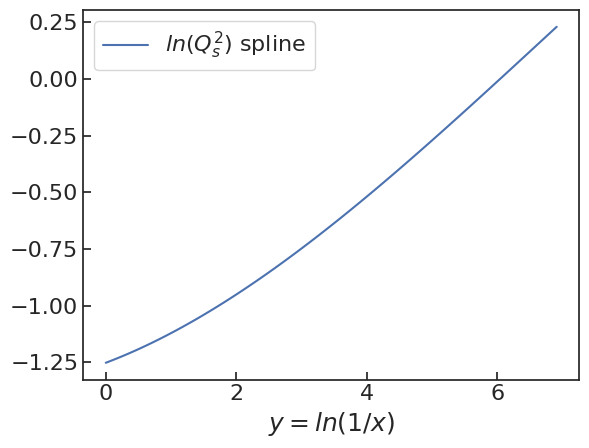

In [201]:
from scipy.interpolate import UnivariateSpline
y = [np.log(0.01/x) for x in xs]
ln_qs2 = [np.log(qs2) for qs2 in mean]
spl = UnivariateSpline(y[::-1], ln_qs2[::-1], s = 0.5)
spl_der = spl.derivative()
lmbd = spl_der(y)
plt.plot(y, spl(y), label = "$ln (Q_{s}^{2})$ spline")
#plt.plot(y, lmbd, '--', label = "$\lambda$")
plt.xlabel("$y = ln(1/x)$")
plt.legend()

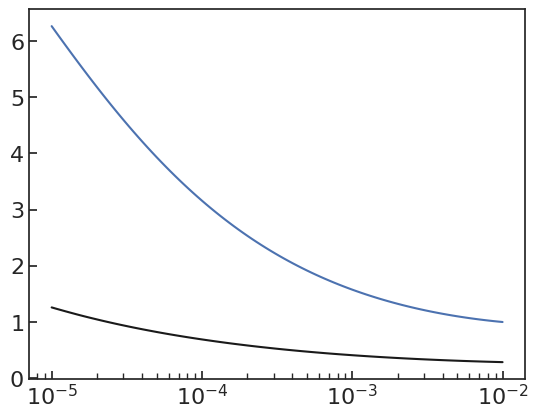

In [199]:
xlmbd = [(0.01/xs[i])**(lmbd[i]) for i in range(len(xs))]
plt.plot(xs, mean, color = 'k')
plt.plot(xs, xlmbd)
plt.xscale('log')

## Initial Dipole Amplitude Shape

In the following, we show the initial and evolved dipole amplitude that is constrained by the Bayesian analysis. The initial dipole amplitude is of the form:

$$ N(\mathbf{x}_{ij}, x=x_0) = 1-\exp \left[  - \frac{\left(\mathbf{x}_{ij}^2Q_{s,0}^2\right)^\gamma}{4} \right.
            \times \left. \ln \left( \frac{1}{|\mathbf{x}_{ij}| \Lambda_\text{QCD}}
             +  e_c\cdot  e   \right)   \right]. $$

We can see clearly here the model parameters that express the dipole amplitude. This is input to the BK evolution equation to evolve the dipole amplitude to higher energie and smaller $x$. The running strong coupling in the transverse plane is also input and is given by:

$$ \alpha_s(\mathbf{r}^2) = \frac{12\pi}{33-2n_f \ln\left( \frac{4C^2}{\mathbf{r}^2 \Lambda_{\mathrm{QCD}}^2} \right)}. $$

In [ ]:
rs = np.logspace(-2,1,50)
iBK = get_iBK_upsd_downsd(Qs02s, gammas, e_cs, rs)
iBK_comp = get_iBK_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, rs)

# plot evolved bk now
where_bk_mve = "data/mve/corr/bks"
eBK_mve = get_eBK_upsd_downsd(where_bk_mve, rs)
where_bk_mv5 = "data/mv5/corr/bks"
eBK_mv5 = get_eBK_upsd_downsd(where_bk_mv5, rs)

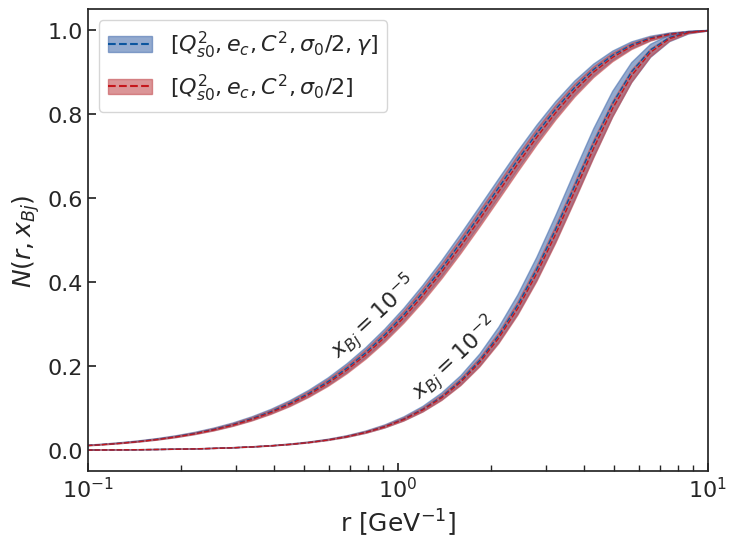

In [ ]:
n_sigma = 2
iBK_mve = iBK_comp if model_ == "mv5" else iBK
iBK_mv5 = iBK if model_ == "mv5" else iBK_comp

fig, ax = plt.subplots(1,1, figsize = (8,6))
plot_pred_mve_vs_mv5(fig,ax, eBK_mve, eBK_mv5, rs, linewidth_ = 1.0, n_sigma=n_sigma)
plot_pred_mve_vs_mv5(fig,ax, iBK_mve, iBK_mv5, rs, r"$N(r,x_{Bj})$", "r [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0, n_sigma=n_sigma)

ax.set_xscale("log")
ax.set_xlim(.1, 10)
ax.text(0.38, 0.25, r'$x_{Bj} = 10^{-5}$', transform=ax.transAxes, rotation = 43, fontsize = 16)
ax.text(0.51, 0.16, r'$x_{Bj} = 10^{-2}$', transform=ax.transAxes, rotation = 43, fontsize = 16)
ax.margins(x = 0.0)
fig.savefig("plots/{}_iebk.pdf".format(correlated_str), bbox_inches='tight') if n_sigma == 2 else fig.savefig("plots/{}_{}sigma_iebk.pdf".format(correlated_str, n_sigma), bbox_inches='tight')

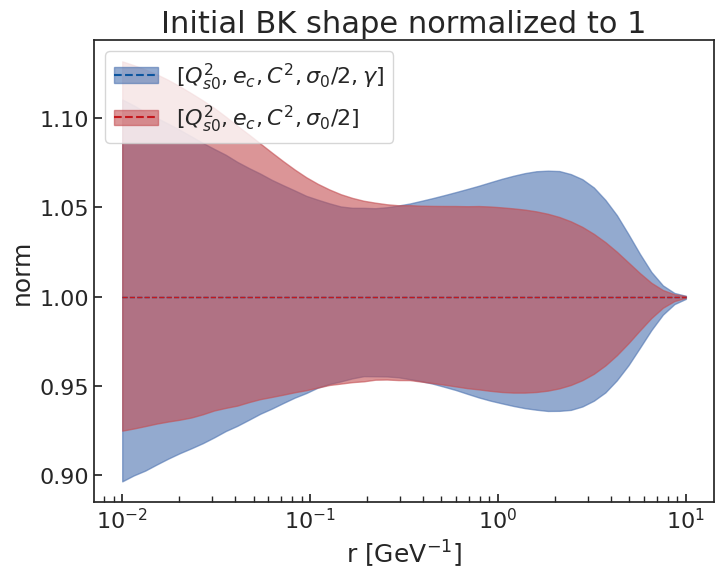

In [ ]:
# normalize to 1
iBK_norm = iBK/iBK[0]
iBK_comp_norm = iBK_comp/iBK_comp[0]

#evolved bk normalize to 1
eBK_mve_norm = eBK_mve/eBK_mve[0]
eBK_mv5_norm = eBK_mv5/eBK_mv5[0]

# plot
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, iBK_comp_norm, iBK_norm, rs, 'norm', "r [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0)
ax.set_title("Initial BK shape normalized to 1")
ax.set_xscale("log")

## 2DFT Dipole Amplitude

Given the optimal parameter vector distribution, we can optimize the initial condition for the BK equation where the agreement with HERA is max. Using these "initial conditions", we can provide CGC LO prediction for observables describing pp and pA collisions at the LHC (and in the future, EIC) like particle production. One example is the 2D fourier transform of the dipole proton amplitude which can be directly calculated from the initial condition $N(r)$:


$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

In [ ]:
k = np.logspace(-1,1,50)
sp = get_2DFT_upsd_downsd(Qs02s, gammas, e_cs, sigma02s, k)
sp_comp = get_2DFT_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, sigma02s_comp, k)

In [ ]:
# what is the uncertainty and mean at a given k?
k_ex = [2.0]
sp_ex = get_2DFT_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, sigma02s_comp, k_ex)
print("Values at an example k = {}: ".format(k_ex))
print("Mean:", sp_ex[0])
print('ratio between mean and upper band:', (sp_ex[0] + 2 * sp_ex[1])/sp_ex[0])
print('ratio between mean and lower band:',  (sp_ex[0] - 2 * sp_ex[2])/sp_ex[0])

Values at an example k = [2.0]: 
Mean: [0.005]
ratio between mean and upper band: [2.566]
ratio between mean and lower band: [0.674]


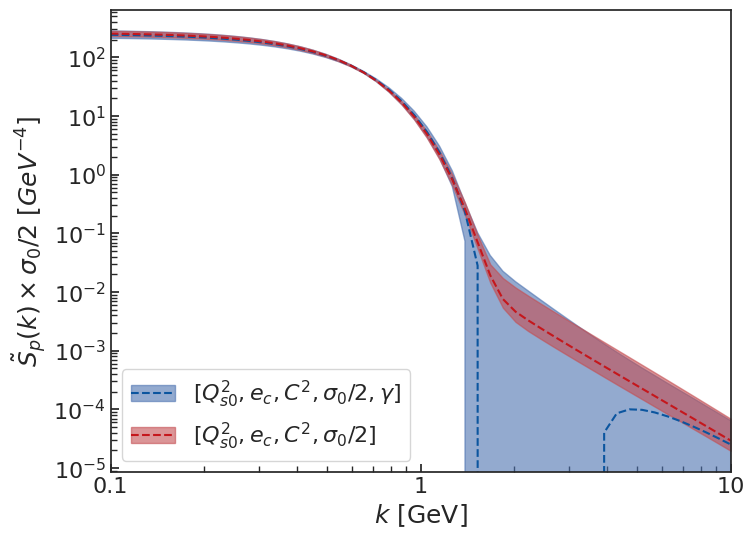

In [ ]:
sp_mve = sp_comp if model_ == "mv5" else sp
sp_mv5 = sp if model_ == "mv5" else sp_comp
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, sp_mve, sp_mv5, k, r'$\tilde{S}_{p}(k) \times \sigma_{0}/2 ~[GeV^{-4}]$', "$k$ [GeV]", legend_loc = "lower left", xlogscale= True, ylogscale = True, linewidth_=1.5)
ax.set_xlim(.1, 10)
#ax.margins(x = 0.0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
fig.savefig("plots/{}_sps.pdf".format(correlated_str), bbox_inches='tight')

Text(0.5, 1.0, '$\\tilde{S}_{p}(k) \\times \\sigma_{0}/2$ normalized to 1')

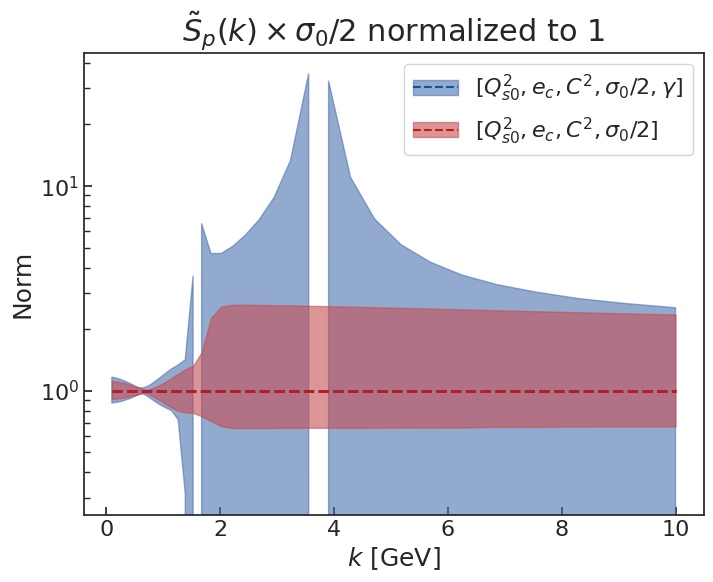

In [ ]:
sp_norm = sp/sp[0]
sp_comp_norm = sp_comp/sp_comp[0]
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, sp_comp_norm, sp_norm, k, 'Norm', "$k$ [GeV]", legend_loc = "upper right", ylogscale = True)
ax.set_title(r"$\tilde{S}_{p}(k) \times \sigma_{0}/2$ normalized to 1")

# $R_{eA}$, nuclear modification ratio

We define the nulear modification factor for the structure function, $F_{2}$ as

$$R_{eA} = \frac{F_{2,A}}{A F_{2,p}}$$

where $F_{2,A}$ is the structure function for the nucleus, (in this study we use a gold nucleus where $A = 197$) and $F_{2,p}$ is the structure function for the proton. First we calculate CGC mean prediction and uncertainties for the Bjorken x dependence of $R$ and then the $Q^2$ dependence using the same procedure as outlined before: using 100 samples from the posterior.

Note: In this calculation, we do not have a routine to calculate the nuclear modification ratio $R_{eA}$ locally, but rather have a separate script that calculates $R_{eA}$ for a given set of parameters. We instead import the datafiles from calculations we already did. 

In [ ]:
where_rpa_q2_mv5 = "../BayesianBK/rpa_mv5/q2dep/"
where_rpa_q2_mve = "../BayesianBK/rpa_mve/q2dep/"
rpa_q2_mv5 = get_rpa_upsd_downsd(where_rpa_q2_mv5)
rpa_q2_mve = get_rpa_upsd_downsd(where_rpa_q2_mve)
Q2_range = np.geomspace(1, 100, 50)
x = 0.001

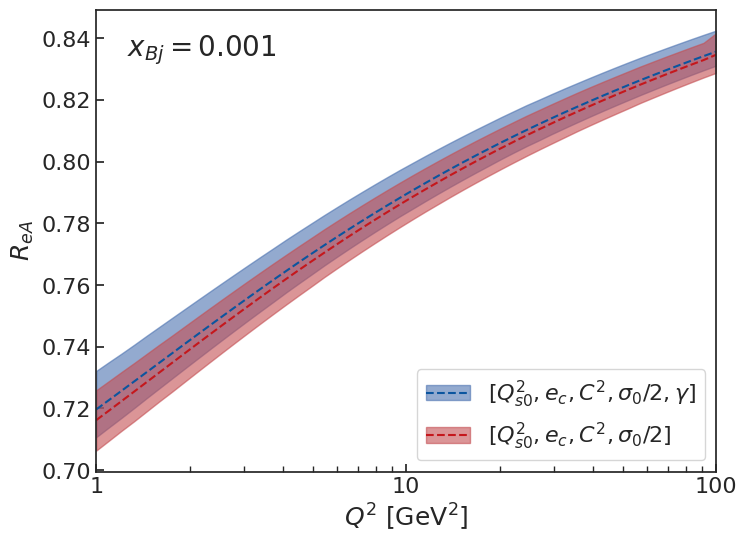

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_q2_mve, rpa_q2_mv5, Q2_range, r'$R_{eA}$', r'$Q^2$ [GeV$^2$]', legend_loc = "lower right", xlogscale= True, linewidth_= 1.5)
ax.text(0.05, 0.95, r'$x_{Bj} = $'+'{}'.format(x), transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')
ax.set_xlim(1, 100)
#ax.set_axes_margin(0.0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
fig.savefig("plots/{}_rpa_q2dep.pdf".format(correlated_str), bbox_inches='tight')
fig.savefig("plots/{}_rpa_q2dep.png".format(correlated_str), bbox_inches='tight')

Text(0.5, 1.0, '$R_{eA}$ normalized to 1')

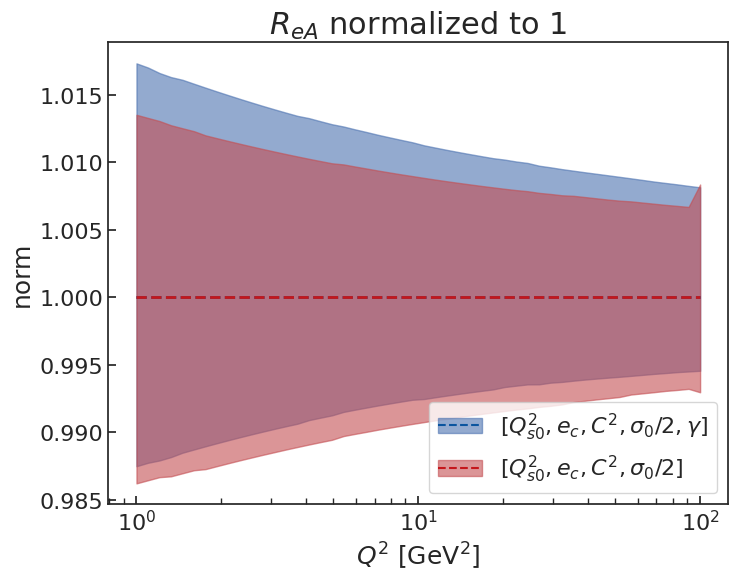

In [ ]:
# normalize to 1
rpa_q2_mv5_norm = rpa_q2_mv5/rpa_q2_mv5[0]
rpa_q2_mve_norm = rpa_q2_mve/rpa_q2_mve[0]
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_q2_mve_norm, rpa_q2_mv5_norm, Q2_range, 'norm', r'$Q^2$ [GeV$^2$]', legend_loc = "lower right", xlogscale= True)
ax.set_title(r'$R_{eA}$ normalized to 1')

In [ ]:
Q2 = 10.0
x_range = np.logspace(-5, -2, 50)
where_rpa_x_mv5 = "../BayesianBK/rpa_mv5/xdep/"
where_rpa_x_mve = "../BayesianBK/rpa_mve/xdep/"
rpa_x_mv5 = get_rpa_upsd_downsd(where_rpa_x_mv5)
rpa_x_mve = get_rpa_upsd_downsd(where_rpa_x_mve)

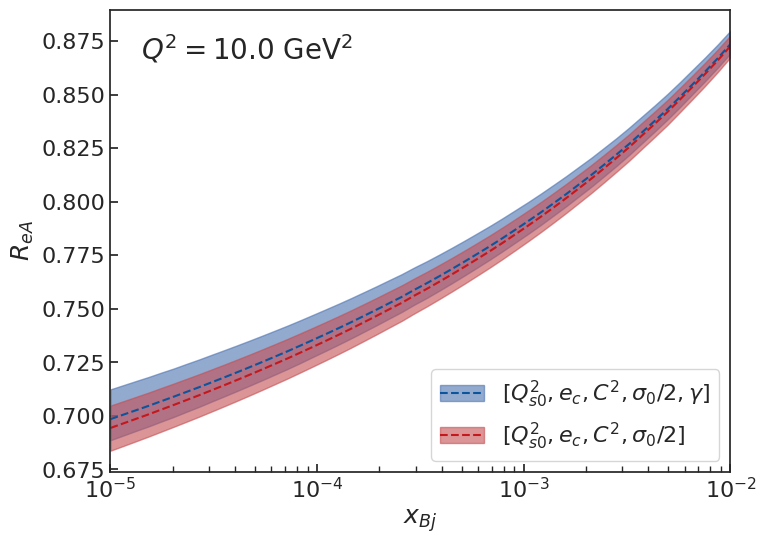

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_x_mve, rpa_x_mv5, x_range, r'$R_{eA}$', r'$x_{Bj}$', legend_loc = "lower right", xlogscale= True, linewidth_= 1.5)
ax.text(0.05, 0.95, r'$Q^2 =${} GeV$^2$'.format(Q2), transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')
ax.set_xlim(1e-5, 1e-2)
#ax.set_axes_margin(0.0)
fig.savefig("plots/{}_rpa_xdep.pdf".format(correlated_str), bbox_inches='tight')
fig.savefig("plots/{}_rpa_xdep.png".format(correlated_str), bbox_inches='tight')

Text(0.5, 1.0, '$R_{eA}$ normalized to 1')

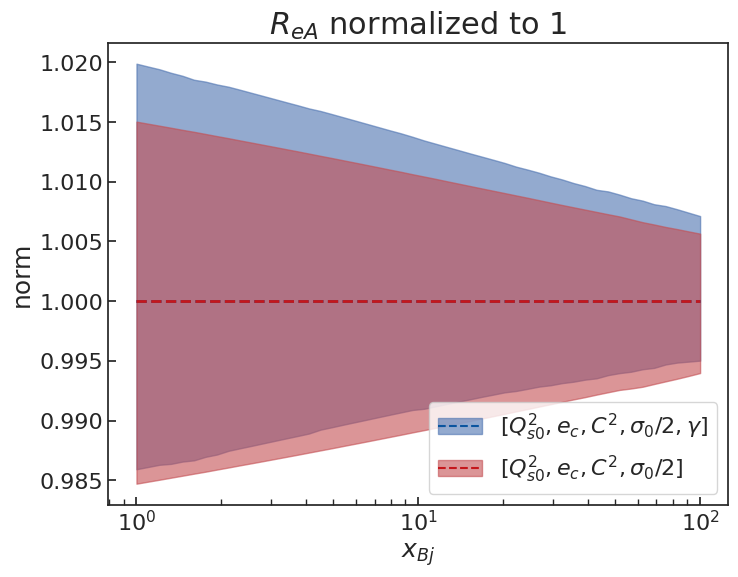

In [ ]:
# typical uncertainty level
rpa_x_mv5_norm = rpa_x_mv5/rpa_x_mv5[0]
rpa_x_mve_norm = rpa_x_mve/rpa_x_mve[0]
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_x_mve_norm, rpa_x_mv5_norm, Q2_range, 'norm', r'$x_{Bj}$', legend_loc = "lower right", xlogscale= True)
ax.set_title(r'$R_{eA}$ normalized to 1')